# Julia methods as actors

## Installing necessary requirements

1) Install Julia itself. Start from here: <http://julialang.org/downloads/>

2) Install `PyCall` which is a Python binding library for Julia (i.e. calling Python from Julia).

```julia
julia> Pkg.update()
julia> Pkg.add("PyCall")
```

3) Install `pyjulia` Python package:

3a) Download it from github.com: 

```bash
git clone git@github.com:JuliaLang/pyjulia.git
```

3b) Install the package:

```bash
cd pyjulia
pip install .              # Copy to site-packages
# pip install -e .         # Makes link to current directory in site-packages
```

4) Try in Python:

```python
import julia
jl = julia.Julia()        # Takes a few seconds
jl.eval("2 + 2")          # Should immediately return "4"
```

In [1]:
%load_ext autoreload
%autoreload(2)

In [2]:
from wowp.actors.julia import JuliaMethod
from wowp.schedulers import LinearizedScheduler
import numpy as np

## Simple calling

In [3]:
sqrt = JuliaMethod("sqrt", inports="a")
sqrt(4)

2.0

## Calling on numpy arrays

In [4]:
sqrt = JuliaMethod("sqrt", inports="a")

array = np.random.rand(5, 5)
scheduler = LinearizedScheduler()
scheduler.put_value(sqrt.inports.a, array)
scheduler.execute()
sqrt.outports.result.pop()

array([[ 0.91379381,  0.76452054,  0.62925355,  0.62860044,  0.42112238],
       [ 0.57866373,  0.47615751,  0.96195498,  0.41679105,  0.91152029],
       [ 0.48007553,  0.94239266,  0.98561812,  0.72003329,  0.79679892],
       [ 0.67424912,  0.68200927,  0.89729095,  0.61858826,  0.56059416],
       [ 0.18894945,  0.53575159,  0.5243968 ,  0.67798176,  0.90987452]])

## Chain sqrt method to pass numpy arrays

In [5]:
sqrt = JuliaMethod("sqrt", inports="a")
sqrt2 = JuliaMethod("sqrt", inports="a")

sqrt.outports.result.connect(sqrt2.inports.a)

array = np.random.rand(5, 5)
scheduler = LinearizedScheduler()
scheduler.put_value(sqrt.inports.a, array)
scheduler.execute()
sqrt2.outports.result.pop()

array([[ 0.49515004,  0.7059926 ,  0.75179199,  0.89298972,  0.68658485],
       [ 0.54016483,  0.70598213,  0.72611978,  0.81153936,  0.65909235],
       [ 0.86581432,  0.95754091,  0.99006334,  0.94470668,  0.66350372],
       [ 0.89233693,  0.95196157,  0.98033928,  0.59451821,  0.74976972],
       [ 0.4110181 ,  0.73543385,  0.93298482,  0.96431895,  0.83253339]])

## Using method from a package

In [6]:
%%file ABCD.jl

module ABCD

VERSION < v"0.4-" && using Docile

export quad

@doc doc"""Fourth power of the argument.""" ->
function quad(a)
    a ^ 4
end

end

Overwriting ABCD.jl


In [7]:
quad = JuliaMethod(package_name="ABCD", method_name="quad", inports="a")
quad(4.0)

256.0

In [8]:
quad.name

'ABCD.quad'

### Non-existent module or package

In [9]:
xxx = JuliaMethod(package_name="ABBD", method_name="x")
xxx()

JuliaError: Exception 'ErrorException' ocurred while calling julia code:
<couldn't get stack>

Code:
using ABBD

In [10]:
xxx = JuliaMethod(package_name="ABCD", method_name="xx")
xxx()

JuliaError: Exception 'UndefVarError' ocurred while calling julia code:
<couldn't get stack>

Code:
ABCD.xx

### Unicode identifiers

The page of julia states that unicode identifiers are not valid. This is true for automatically imported methods. But not for `JuliaMethod`. Names like `πtimes!` are fine :-)

In [11]:
%%file UnicodePi.jl

module UnicodePi

VERSION < v"0.4-" && using Docile

export πtimes!

@doc doc"""Return pi times argument""" ->
function πtimes!(a)
    π * a
end

end

Overwriting UnicodePi.jl


In [14]:
pi_times = JuliaMethod(package_name="UnicodePi", method_name="πtimes!", inports="x")
print(pi_times.name)
pi_times(4)

UnicodePi.πtimes!


12.566370614359172

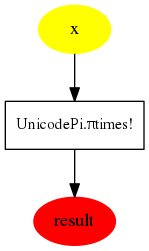

In [15]:
from wowp.tools.plotting import ipy_show
ipy_show(pi_times)